In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

# Data

In [3]:
df = pd.read_csv('./data/final_0509.csv')

In [4]:
cols = list(df.columns)
cols.remove('Date')

In [5]:
df[cols] = df[cols].astype(int)

In [6]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
df.Date = pd.to_datetime(df.Date)
#df['dayofweek'] = df['Date'].dt.dayofweek
df.set_index('Date', inplace=True)

In [8]:
lag_col= list(df.columns)

In [9]:
lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
    
df.dropna(inplace=True)

In [10]:
df.isnull().sum().sum()

0

In [11]:
df.rename(columns={'TARGET':'target'},inplace=True)

In [12]:
covid = df

In [13]:
covid.tail()

,MM_conf,LA_conf,NL_conf,PH_conf,RU_conf,KR,TW_conf,US_conf,AE_conf,GB_conf,...,news_lag3,covid_tr_lag1,covid_tr_lag2,covid_tr_lag3,coro_tr_lag1,coro_tr_lag2,coro_tr_lag3,target_lag1,target_lag2,target_lag3
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,0,0,476,284,7933,6,0,34037,557,6204,...,1763.0,43.0,63.0,59.0,18.0,18.0,18.0,4.0,5.0,12.0
2020-05-02,0,0,445,156,9623,13,3,29078,561,4815,...,1117.0,48.0,43.0,63.0,18.0,18.0,18.0,8.0,4.0,5.0
2020-05-03,4,0,335,295,10633,8,4,25501,564,4342,...,1266.0,43.0,48.0,43.0,18.0,18.0,18.0,8.0,8.0,4.0
2020-05-04,6,0,199,262,10581,3,2,22335,567,3990,...,1104.0,55.0,43.0,48.0,18.0,18.0,18.0,10.0,8.0,8.0
2020-05-05,0,0,318,199,10102,2,0,23976,462,4411,...,732.0,30.0,55.0,43.0,17.0,18.0,18.0,8.0,10.0,8.0


In [14]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

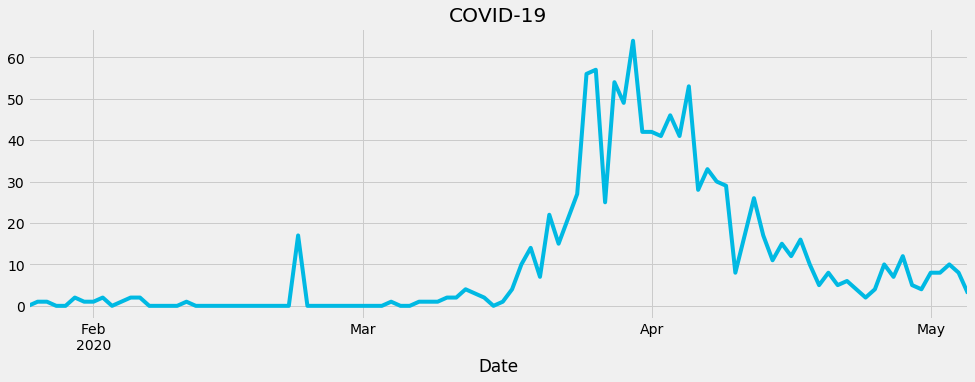

In [15]:
_ = covid['target'].plot(style='-', figsize=(15,5), color=color_pal[5], title='COVID-19')

# Train/Test Split

In [16]:
covid.index = pd.to_datetime(covid.index)

In [19]:
split_date = '2020-04-14'
df_train = covid.loc[covid.index <= split_date].copy()
df_test = covid.loc[covid.index > split_date].copy()

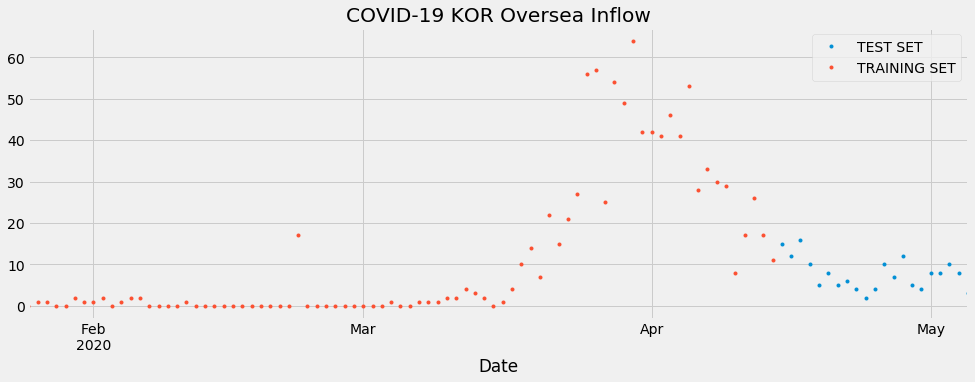

In [20]:
_ = df_test[['target']] \
    .rename(columns={'target': 'TEST SET'}) \
    .join(df_train[['target']].rename(columns={'target': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='COVID-19 KOR Oversea Inflow', style='.')

# Create Time Series Features

In [21]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
#    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
#    df['dayofyear'] = df['date'].dt.dayofyear
#    df['dayofmonth'] = df['date'].dt.day
#    df['weekofyear'] = df['date'].dt.weekofyear
    
    X_cols = list(df.columns)
    X_cols.remove('{}'.format(label))
    X_cols.remove('{}'.format('date'))
    X = df[X_cols]
    if label:
        y = df[label]
        return X, y
    return X

In [22]:
X_train, y_train = create_features(df_train, label='target')
X_test, y_test = create_features(df_test, label='target')

# Create XGBoost Model

In [23]:
reg = xgb.XGBRegressor(n_estimators=200,gamma=0.3, learning_rate=0.015)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.015, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

# Feature Importances

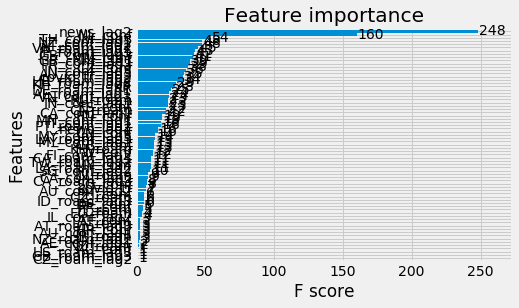

In [24]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test Set

In [25]:
df_test['pred'] = reg.predict(X_test).astype(int)
df_all = pd.concat([df_test, df_train], sort=False)

In [26]:
# validation score
score = 100*(1-(((df_test['pred'] - df_test['target'])**2).sum())/((df_test['target']**2).sum()))

In [27]:
score

77.7490297542044

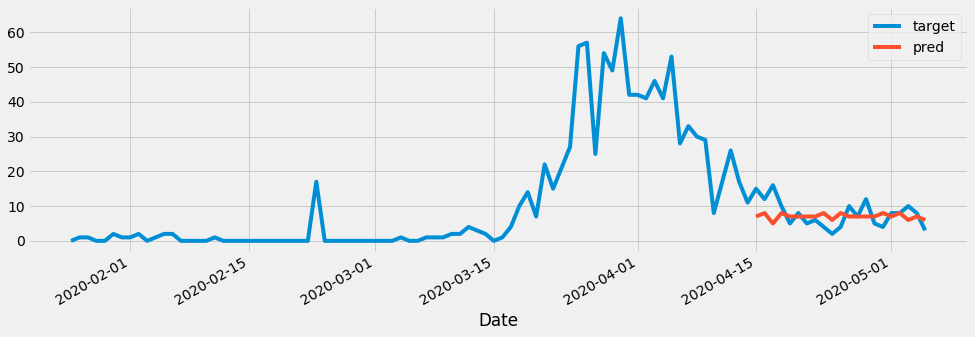

In [28]:
_ = df_all[['target','pred']].plot(figsize=(15, 5))

# Plot the forecast with the actuals

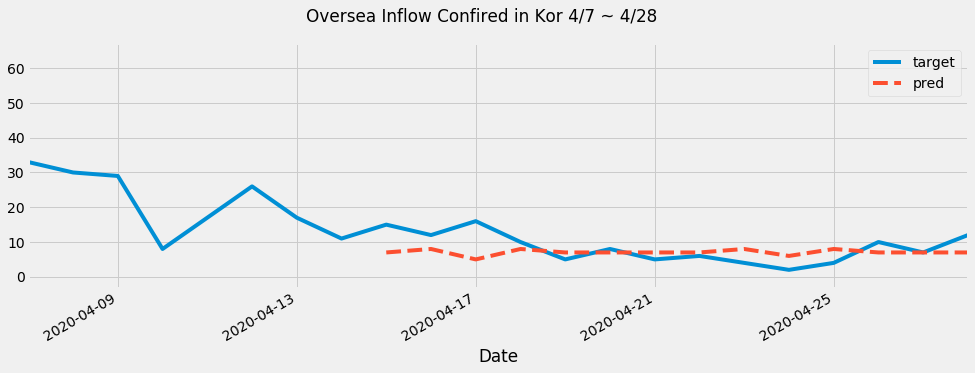

In [29]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['target','pred']].plot(ax=ax,
                                              style=['-','--'])
ax.set_xbound(lower='2020-04-07', upper='2020-04-28')
#ax.set_ylim(0, 60000)
plot = plt.suptitle('Oversea Inflow Confired in Kor 4/7 ~ 4/28')

# Error Metrics On Test Set

In [30]:
# validation score
score = 100*(1-(((df_test['pred'] - df_test['target'])**2).sum())/((df_test['target']**2).sum()))

In [31]:
score

77.7490297542044

In [32]:
mean_squared_error(y_true=df_test['target'],
                   y_pred=df_test['pred'])

16.38095238095238

In [33]:
mean_absolute_error(y_true=df_test['target'],
                   y_pred=df_test['pred'])

3.142857142857143

In [34]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [35]:
mean_absolute_percentage_error(y_true=df_test['target'],
                   y_pred=df_test['pred'])

50.535714285714285